# Classical Computing Approaches to the Traveling Salesman Problem

The approaches explored are
* Brute Force - Naive approach to solving the TSP. Yields optimal solution.
* Nearest Neighbor - The Hamiltonian path traversed is done through choosing the closest node to travel to next.
* Simulated Annealing - Use a random path to then better paths with an annealing approach.
* Simulated Annealing with Nearest Neighbor as Initial Path

In [8]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms.optimizers import SPSA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from scipy.optimize import minimize
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session
from qiskit.circuit.library import QAOAAnsatz
from qiskit_optimization.converters import QuadraticProgramToQubo
from itertools import permutations

from SA_NN_Class import SA_NN


import time


In [9]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


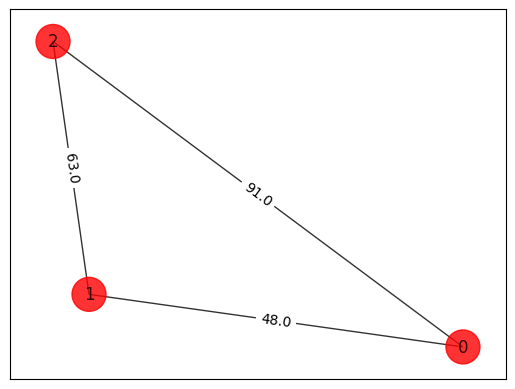

In [10]:
n = 3 #number of nodes in the TSP
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [11]:
qp = tsp.to_quadratic_program()
# print(qp.prettyprint())

In [12]:

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [ ]:
JESS_Token = "03ed20e2ac722b01fec7ed9cdda2c78416f74c6f760c6d0e5d287f804e771418d02d66f40d0be6d1256caf32ef23f5537fd9c0ccbb4046b120c787fbabdb11d5"
AIDAN_Token = "9ef8aefb2a8761e877e2f93f4bc957eb2e692dd0f54890189f494ff1eb147d9f6202033185155b894e9a1d9efb8fa8b6c7130df9a8498123e9d40a14729f9afc"

QiskitRuntimeService.save_account(channel="ibm_quantum", token=JESS_Token,overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.backend("ibm_kyoto")

In [7]:
hamiltonian = qubitOp
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)


In [8]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)

In [9]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [12]:
session = Session(backend=backend)
# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10000
# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10000


In [13]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [14]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to the circuit
qc.measure_all()
qc_isa = pm.run(qc)


In [ ]:
result = sampler.run([qc_isa]).result()

In [ ]:
prob_distribution_routes = result.quasi_dists[0]

In [ ]:
dictionary_routes = dict(sorted(distribution.binary_probabilities().items(),key=lambda item: item[1], reverse=True))


The above line is used to sort the binary outcomes of `prob_distribution_routes`, which represents the probabilities of different solutions to the Traveling Salesman Problem (TSP), ranked on their likelihood of being ideal. In the context of the TSP, each binary string represents a potential route for the graph theory Hamiltonian.

In [4]:
arrays = []

# Iterate over the keys of the dictionary
for key in my_dict.keys():
    # Convert the key to a numpy array of integers and append it to the list
    arrays.append(np.array([int(bit) for bit in key]))

# Convert the list of arrays to a numpy array
result = np.array(arrays)

print(result)

NameError: name 'my_dict' is not defined

In [ ]:
x = result[0]

In [ ]:
print("feasible:", qubo.is_feasible(x))

In [ ]:
z = tsp.interpret(x)
print("solution:", z)

In [13]:
# Function to generate a random instance of TSP
def generate_tsp_instance(n, seed=123):
    tsp = Tsp.create_random_instance(n, seed=seed)
    return tsp

# Function to calculate the total distance of a tour
def calculate_total_distance(tour, adj_matrix):
    total_distance = 0
    n = len(tour)
    for i in range(n - 1):
        total_distance += adj_matrix[tour[i], tour[i + 1]]
    total_distance += adj_matrix[tour[-1], tour[0]]  # Close the loop
    return total_distance

# Function to solve TSP using brute force
def brute_force_tsp(adj_matrix):
    start_time = time.time()
    n = len(adj_matrix)
    best_order = None
    best_distance = np.inf
    for order in permutations(range(n)):
        total_distance = calculate_total_distance(order, adj_matrix)
        if total_distance < best_distance:
            best_distance = total_distance
            best_order = order
    end_time = time.time()
    time_taken = end_time - start_time
    return best_distance, best_order, time_taken

# Generate TSP instance
n = 9  # Number of nodes in the TSP
tsp = generate_tsp_instance(n)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("Distance Matrix:\n", adj_matrix)

# Solve TSP using brute force
best_distance, best_order, time_taken = brute_force_tsp(adj_matrix)
print("Best order from brute force:", best_order, "with total distance:", best_distance)
print("Time taken:", time_taken, "seconds")

# Plot the TSP solution
colors = ["r" for node in tsp.graph.nodes]
pos = nx.spring_layout(tsp.graph)  # Get node positions for plotting
draw_tsp_solution(tsp.graph, best_order, colors, pos)

Distance Matrix:
 [[ 0. 48. 91. 33. 85. 26. 21. 58. 30.]
 [48.  0. 63. 71. 93. 30. 60. 69. 71.]
 [91. 63.  0. 92. 65. 66. 88. 59. 95.]
 [33. 71. 92.  0. 62. 41. 12. 40.  4.]
 [85. 93. 65. 62.  0. 71. 68. 27. 67.]
 [26. 30. 66. 41. 71.  0. 31. 45. 41.]
 [21. 60. 88. 12. 68. 31.  0. 42. 10.]
 [58. 69. 59. 40. 27. 45. 42.  0. 44.]
 [30. 71. 95.  4. 67. 41. 10. 44.  0.]]
Best order from brute force: (0, 5, 1, 2, 4, 7, 3, 8, 6) with total distance: 286.0
Time taken: 1.0253102779388428 seconds


NameError: name 'draw_tsp_solution' is not defined

Distance Matrix:
 [[ 0. 48. 91. 33. 85. 26. 21. 58. 30. 48. 46.]
 [48.  0. 63. 71. 93. 30. 60. 69. 71. 67.  2.]
 [91. 63.  0. 92. 65. 66. 88. 59. 95. 69. 65.]
 [33. 71. 92.  0. 62. 41. 12. 40.  4. 27. 70.]
 [85. 93. 65. 62.  0. 71. 68. 27. 67. 37. 93.]
 [26. 30. 66. 41. 71.  0. 31. 45. 41. 40. 29.]
 [21. 60. 88. 12. 68. 31.  0. 42. 10. 31. 59.]
 [58. 69. 59. 40. 27. 45. 42.  0. 44. 13. 69.]
 [30. 71. 95.  4. 67. 41. 10. 44.  0. 31. 70.]
 [48. 67. 69. 27. 37. 40. 31. 13. 31.  0. 67.]
 [46.  2. 65. 70. 93. 29. 59. 69. 70. 67.  0.]]
Tour (K-nearest neighbor): [0, 6, 8, 3, 9, 7, 4, 2, 1, 10, 5]
Tour length (K-nearest neighbor): 287.0
Time taken: 0.0 seconds


C:\Users\jessd\AppData\Local\Temp\ipykernel_28160\498208463.py:67: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_knn[-1], tour_knn[0])], edge_color='r')  # Close the loop


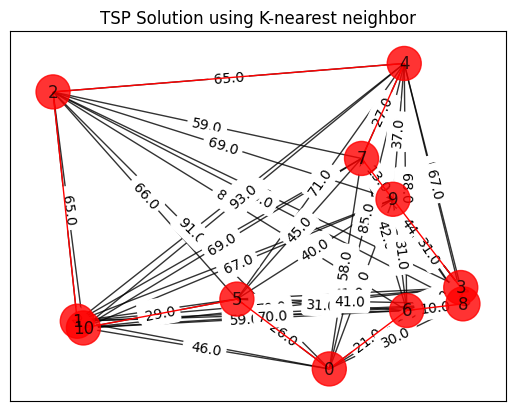

In [14]:

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Function to compute the tour length given a tour
def tour_length(tour, adj_matrix):
    length = 0
    for i in range(len(tour) - 1):
        length += adj_matrix[tour[i]][tour[i+1]]
    length += adj_matrix[tour[-1]][tour[0]]  # Close the loop
    return length

# Function to find the nearest neighbor of a given node
def find_nearest_neighbor(node, visited, adj_matrix):
    min_distance = np.inf
    nearest_neighbor = None
    for neighbor in range(len(adj_matrix)):
        if neighbor != node and neighbor not in visited:
            distance = adj_matrix[node][neighbor]
            if distance < min_distance:
                min_distance = distance
                nearest_neighbor = neighbor
    return nearest_neighbor

# Function to solve TSP using K-nearest neighbor algorithm
def tsp_knn(adj_matrix):
    n = len(adj_matrix)
    start_node = 0  
    tour = [start_node]
    visited = set([start_node])

    while len(visited) < n:
        current_node = tour[-1]
        nearest_neighbor = find_nearest_neighbor(current_node, visited, adj_matrix)
        tour.append(nearest_neighbor)
        visited.add(nearest_neighbor)

    tour_length_knn = tour_length(tour, adj_matrix)
    return tour, tour_length_knn

n = 11  # Number of nodes in the TSP
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("Distance Matrix:\n", adj_matrix)

# Start timing
start_time = time.time()

# Solve TSP using K-nearest neighbor algorithm
tour_knn, tour_length_knn = tsp_knn(adj_matrix)

# End timing
end_time = time.time()

# Print the tour and its length
print("Tour (K-nearest neighbor):", tour_knn)
print("Tour length (K-nearest neighbor):", tour_length_knn)

# Print time taken
print("Time taken:", end_time - start_time, "seconds")

# Plot the graph and the tour
colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)
nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_knn[i], tour_knn[i+1]) for i in range(len(tour_knn)-1)], edge_color='r')
nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_knn[-1], tour_knn[0])], edge_color='r')  # Close the loop
plt.title("TSP Solution using K-nearest neighbor")
plt.show()

Distance Matrix:
 [[ 0. 48. 91. 33. 85. 26. 21. 58. 30. 48. 46.]
 [48.  0. 63. 71. 93. 30. 60. 69. 71. 67.  2.]
 [91. 63.  0. 92. 65. 66. 88. 59. 95. 69. 65.]
 [33. 71. 92.  0. 62. 41. 12. 40.  4. 27. 70.]
 [85. 93. 65. 62.  0. 71. 68. 27. 67. 37. 93.]
 [26. 30. 66. 41. 71.  0. 31. 45. 41. 40. 29.]
 [21. 60. 88. 12. 68. 31.  0. 42. 10. 31. 59.]
 [58. 69. 59. 40. 27. 45. 42.  0. 44. 13. 69.]
 [30. 71. 95.  4. 67. 41. 10. 44.  0. 31. 70.]
 [48. 67. 69. 27. 37. 40. 31. 13. 31.  0. 67.]
 [46.  2. 65. 70. 93. 29. 59. 69. 70. 67.  0.]]
Tour: [ 2  5 10  1  0  3  8  6  7  9  4]
Tour length: 349.0
Time taken: 0.017833948135375977 seconds


C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3915611811.py:64: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_sa[-1], tour_sa[0])], edge_color='b')  # Close the loop


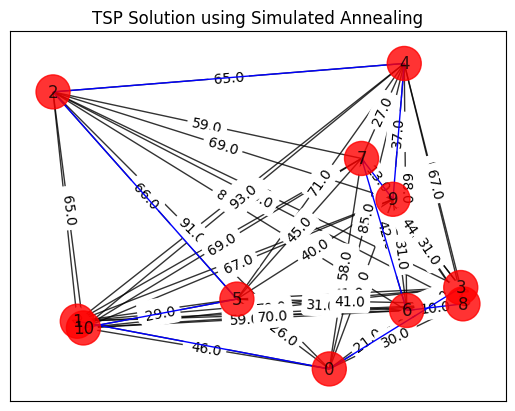

In [8]:
# Function to generate a random initial tour starting from node 0
def generate_initial_tour(n):
    tour = np.arange(1, n)  # Nodes other than 0
    np.random.shuffle(tour)  # Shuffle the nodes
    tour = np.insert(tour, 0, 0)  # Insert node 0 at the beginning
    return tour


# Function to accept or reject a move based on the Metropolis criterion
def accept_move(delta, temperature):
    return np.random.rand() < np.exp(-delta / temperature)

# Function to perform simulated annealing to solve TSP
def tsp_simulated_annealing(adj_matrix, initial_temperature=100, cooling_rate=0.99, num_iterations=1000):
    n = len(adj_matrix)
    current_tour = generate_initial_tour(n)
    current_length = tour_length(current_tour, adj_matrix)
    best_tour = current_tour.copy()
    best_length = current_length

    temperature = initial_temperature
    for _ in range(num_iterations):
        new_tour = np.random.permutation(n)
        new_length = tour_length(new_tour, adj_matrix)
        delta = new_length - current_length

        if delta < 0 or accept_move(delta, temperature):
            current_tour = new_tour.copy()
            current_length = new_length
            if current_length < best_length:
                best_tour = current_tour.copy()
                best_length = current_length

        temperature *= cooling_rate

    return best_tour, best_length

n = 11 # Number of nodes in the TSP
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("Distance Matrix:\n", adj_matrix)

# Start timing
start_time = time.time()

# Solve TSP using simulated annealing algorithm
tour_sa, tour_length_sa = tsp_simulated_annealing(adj_matrix)

# End timing
end_time = time.time()

# Print the tour and its length
print("Tour:", tour_sa)
print("Tour length:", tour_length_sa)

# Print time taken
print("Time taken:", end_time - start_time, "seconds")

# Plot the graph and the tour
colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)
nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_sa[i], tour_sa[i+1]) for i in range(len(tour_sa)-1)], edge_color='b')
nx.draw_networkx_edges(tsp.graph, pos, edgelist=[(tour_sa[-1], tour_sa[0])], edge_color='b')  # Close the loop
plt.title("TSP Solution using Simulated Annealing")
plt.show()

# Simulated Annealing with Nearest Neighbor as initial solution

Coordinates of each node: [[68.23518632  5.38210188]
 [22.03598728 18.43718107]
 [17.59059011 81.20945067]
 [92.3344998  27.65743978]
 [81.97545616 88.98926931]
 [51.29704552 24.49646011]
 [82.42415961 21.37629634]
 [74.14670522 62.99402046]
 [92.74072585 23.19081886]
 [79.91251286 51.81650369]
 [23.15556248 16.59039932]]
Time taken: 0.00024199999461416155
Best fitness obtained:  327.6249133946763
Starting annealing.
Simulated Annealing with Nearest Neighbor Inital Approach
Time taken:  0.10913789999904111
Best fitness obtained:  287.94455323972556


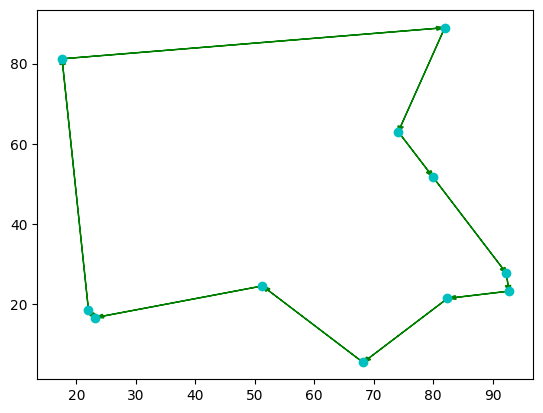

In [19]:
node_positions = nx.get_node_attributes(tsp.graph, 'pos')

# Extract coordinates into an array
coords_array = np.array([pos for pos in node_positions.values()])

print("Coordinates of each node:", coords_array)

# use coords from tsp
SimulatedAnnealing_NearestNeighbor = SA_NN(coords_array, stopping_iter=5000)
SimulatedAnnealing_NearestNeighbor.simulated_annealing()
SimulatedAnnealing_NearestNeighbor.visualize_routes()